# Prac 08.1

In this homework you are going to build your first classifier for the CIFAR-10 dataset. This dataset contains 10 different classes and you can learn more about it [here](https://www.cs.toronto.edu/~kriz/cifar.html). This homework consists of the following tasks:
* Dataset inspection
* Building the network
* Training
* Evaluation

At the end, as usual, there will be a couple of questions for you to answer :-)

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Input, MaxPooling2D
from tensorflow.keras import Model
from time import time

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

# Set the seeds for reproducibility
from numpy.random import seed
from tensorflow.random import set_seed
seed_value = 1234578790
seed(seed_value)
set_seed(seed_value)

### Step 0: Dataset Inspection

Load the dataset and make a quick inspection.

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 64s 0us/step


C:\Users\alexi\AppData\Local\Temp\ipykernel_3184\460949434.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(classes[int(y_train[idx])])


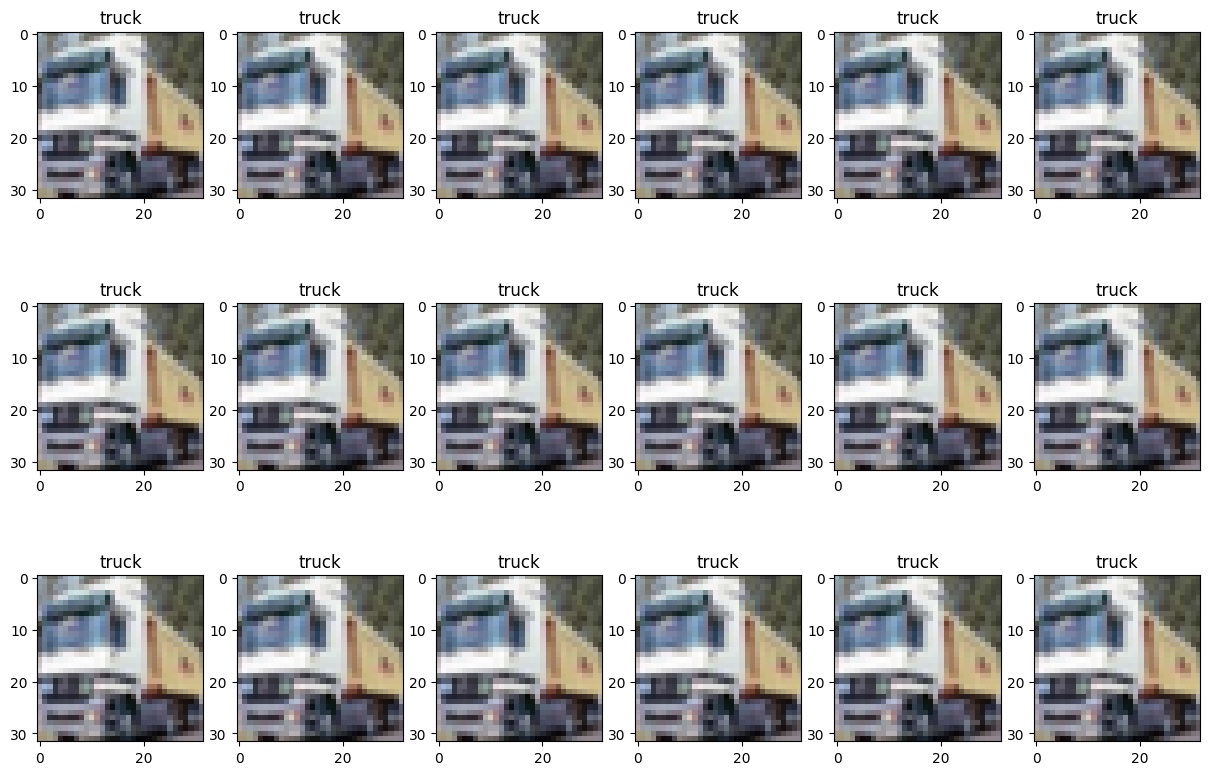

In [2]:
# Load the dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
# Mapping from class ID to class name
classes = {0:'plane', 1:'car', 2:'bird', 3:'cat', 4:'deer',
           5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}

# Dataset params
num_classes = len(classes)
size = x_train.shape[1]

# Visualize random samples (as a plot with 3x6 samples)
for ii in range(18):    
    plt.subplot(3,6,ii+1)
    # Pick a random sample
    idx = 1
    # Show the image and the label
    plt.imshow(x_train[idx, ...])
    plt.title(classes[int(y_train[idx])])

Compute the class histogram (you can visualize it if you want). Is the dataset balanced?

Hint: You might find [Counter](https://docs.python.org/3/library/collections.html#collections.Counter) tool useful. In any case, it's up to you how you compute the histogram.

Text(0, 0.5, 'Frequency')

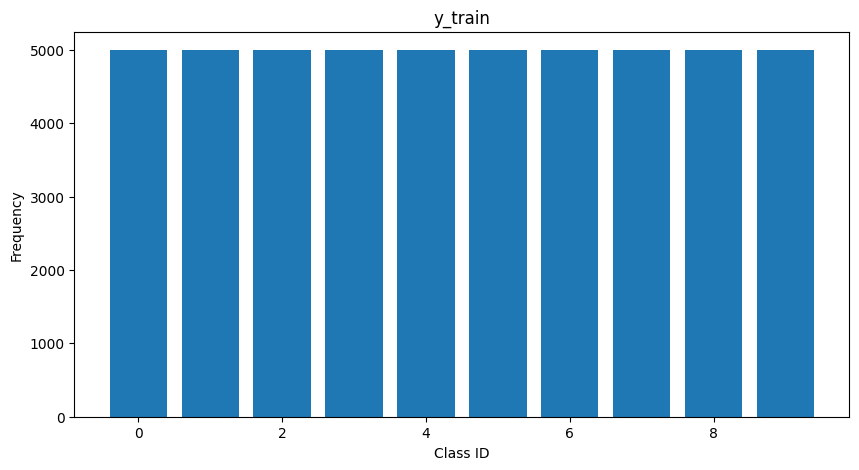

In [3]:
from collections import Counter

histogram = Counter(y_train.flatten())

plt.figure(figsize=(10, 5))
plt.bar(histogram.keys(), histogram.values())
plt.title("y_train")
plt.xlabel("Class ID")
plt.ylabel("Frequency")

Text(0, 0.5, 'Frequency')

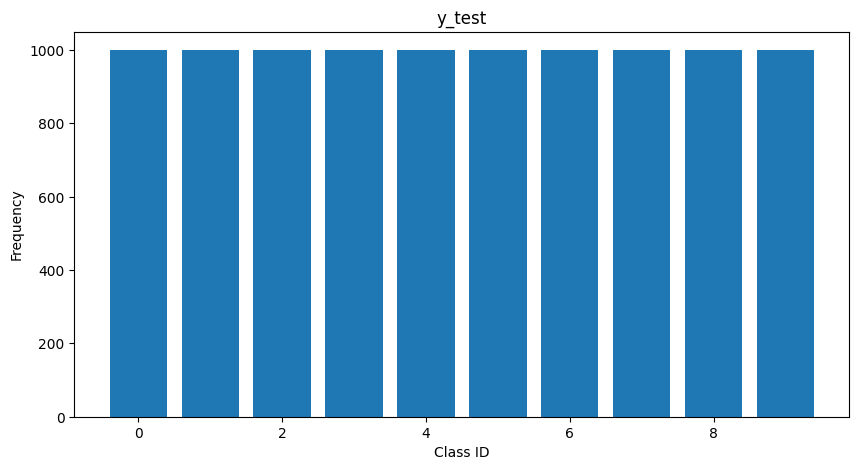

In [4]:
histogram = Counter(y_test.flatten())

plt.figure(figsize=(10, 5))
plt.bar(histogram.keys(), histogram.values())
plt.title("y_test")
plt.xlabel("Class ID")
plt.ylabel("Frequency")

### Step 1: Data Preparation

In this step, you'll need to prepare the data for training, i.e., you will have to normalize it and encode the labels as one-hot vectors.

In [5]:
# Normalization
x_train = x_train / 255.0
x_test = x_test / 255.0

# One-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

print('Train set:   ', len(y_train), 'samples')
print('Test set:    ', len(y_test), 'samples')
print('Sample dims: ', x_train.shape)

Train set:    50000 samples
Test set:     10000 samples
Sample dims:  (50000, 32, 32, 3)


### Step 2: Building the Classifier

Build the CNN for CIFAR10 classification. For starters, you can use the same network we used in the lesson for the MNIST problem.

In [6]:
# Build the classifier
model = tf.keras.Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(size, size, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Show the model
model.summary()

c:\Users\alexi\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 160,202 (625.79 KB)

 Trainable params: 160,202 (625.79 KB)

 Non-trainable params: 0 (0.00 B)

### Step 3: Training

Compile the model and train it.

In [7]:
epochs = 25
batch_size = 128

# Compile the model
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train the model
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 26s 58ms/step - accuracy: 0.2944 - loss: 1.9010 - val_accuracy: 0.4958 - val_loss: 1.4036
Epoch 2/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - accuracy: 0.5037 - loss: 1.3803 - val_accuracy: 0.5574 - val_loss: 1.2793
Epoch 3/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 20s 58ms/step - accuracy: 0.5773 - loss: 1.2000 - val_accuracy: 0.5800 - val_loss: 1.2454
Epoch 4/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 22s 61ms/step - accuracy: 0.6196 - loss: 1.0802 - val_accuracy: 0.6182 - val_loss: 1.1334
Epoch 5/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 23s 64ms/step - accuracy: 0.6517 - loss: 0.9884 - val_accuracy: 0.6528 - val_loss: 1.0172
Epoch 6/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 21s 58ms/step - accuracy: 0.6791 - loss: 0.9210 - val_accuracy: 0.6810 - val_loss: 0.9255
Epoch 7/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.7004 - loss: 0.8618 - val_accuracy: 0.6908 - val_loss: 0.9057
Epoch 8/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 17s 48ms/step - accuracy: 0.7176 - loss: 0.8120 - 

Train Acc      0.8691555261611938
Validation Acc 0.6837999820709229


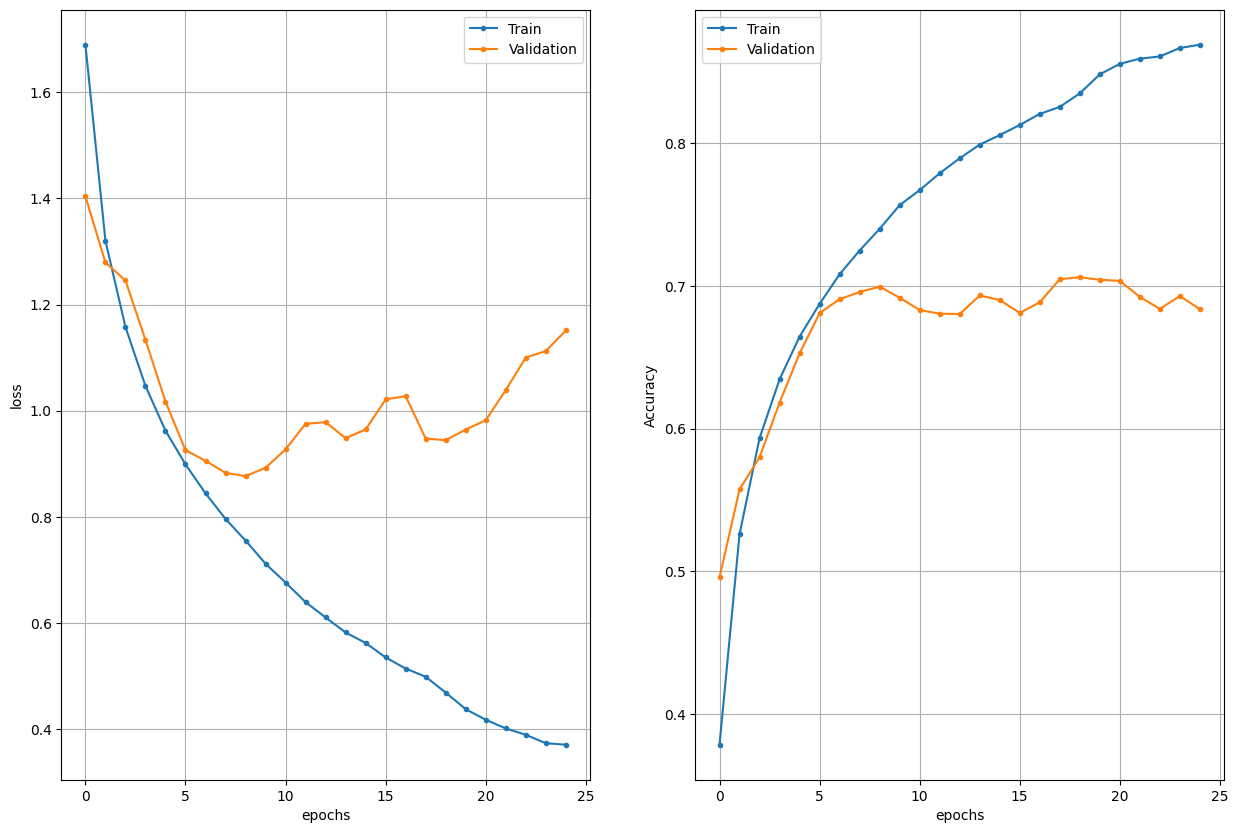

In [8]:
# Show training history (this cell is complete, nothing to implement here :-) )
h = history.history
epochs = range(len(h['loss']))

plt.subplot(121), plt.plot(epochs, h['loss'], '.-', epochs, h['val_loss'], '.-')
plt.grid(True), plt.xlabel('epochs'), plt.ylabel('loss')
plt.legend(['Train', 'Validation'])
plt.subplot(122), plt.plot(epochs, h['accuracy'], '.-',
                           epochs, h['val_accuracy'], '.-')
plt.grid(True), plt.xlabel('epochs'), plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

print('Train Acc     ', h['accuracy'][-1])
print('Validation Acc', h['val_accuracy'][-1])    

### Step 4: Evaluation

In this step, you have to calculate the accuracies and visualize some random samples. For the evaluation, you are going to use the test split from the dataset.

In [11]:
# Compute the labels and the predictions as sparse values
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(model.predict(x_test), axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step


In [12]:
# Compute and print the accuracy for each class
for class_id, class_name in classes.items():
    
    acc = np.mean(y_true == y_pred)
    print(class_name, acc)

plane 0.678
car 0.678
bird 0.678
cat 0.678
deer 0.678
dog 0.678
frog 0.678
horse 0.678
ship 0.678
truck 0.678


In [13]:
# Print the overall stats
ev = model.evaluate(x_test, y_test)
print('Test loss  ', ev[0])
print('Test metric', ev[1])

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.6779 - loss: 1.2010
Test loss   1.207419514656067
Test metric 0.6779999732971191


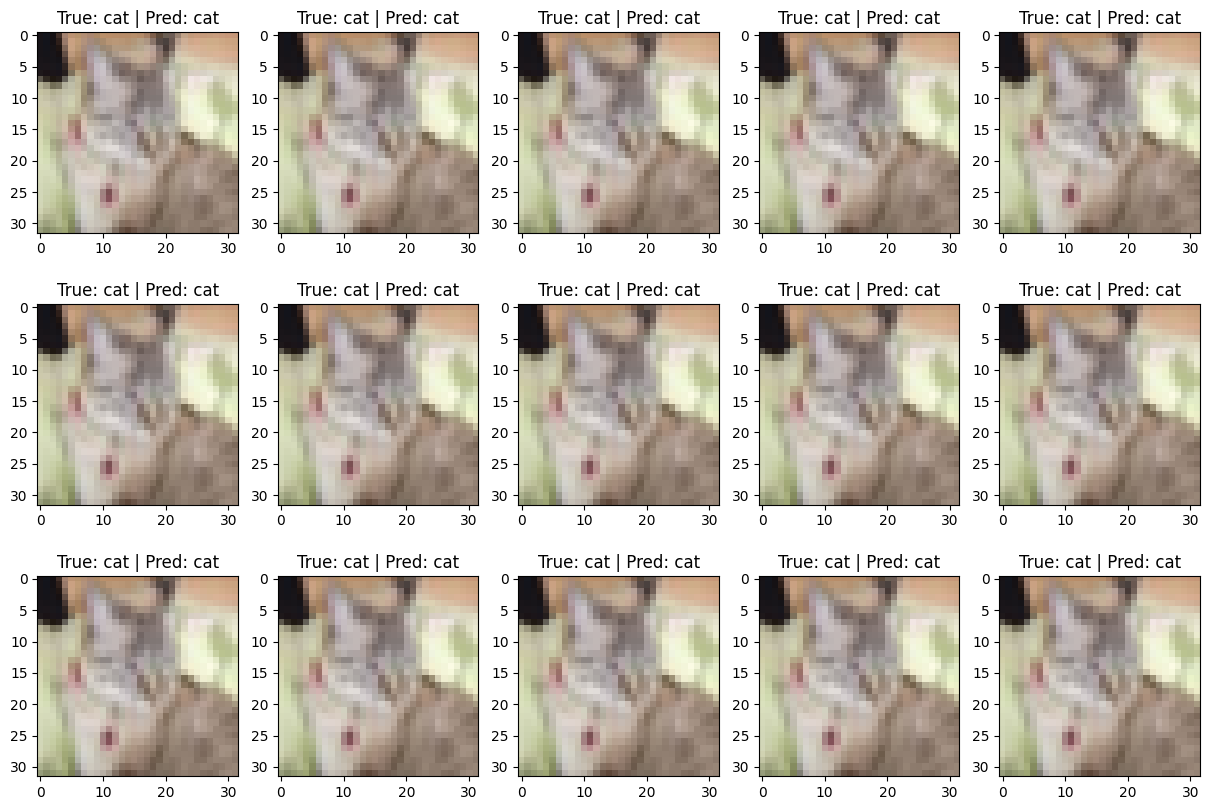

In [15]:
# Show random samples
for ii in range(15):
    # Pick a random sample
    idx = 8
    # Show the results
    plt.subplot(3,5,ii+1), plt.imshow(x_test[idx, ...])
    plt.title('True: ' + str(classes[y_true[idx]]) + ' | Pred: ' + str(classes[y_pred[idx]]))

### Questions
* What is the overall accuracy of the classifier?
* What modifications would you do in order to improve the classification accuracy?
* Make **one** modification (that you think can help) and train the classifier again. Does the accuracy improve?